# Implement Autograd

In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.utils import np_utils
from scipy.special import softmax

np.random.seed(0)

In [32]:
class Tensor (object):
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if id is None:
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if creators is not None:
            for c in creators:
                if self.id not in c.children:
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id, cnt in self.children.items():
            if cnt != 0:
                return False
        return True
      
    def shape(self):
      return self.data.shape
        
    def backward(self, grad=None, grad_origin=None):
        if self.autograd:
            if grad is None:
                grad = FloatTensor(np.ones_like(self.data))
            
            if grad_origin is not None:
                if self.children[grad_origin.id] == 0:
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if self.grad is None:
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            if self.creators is not None and (self.all_children_grads_accounted_for() or grad_origin is None):
                if self.creation_op == "add":
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)

                if self.creation_op == "sub":
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if self.creation_op == "mul":
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self) 

                if self.creation_op == "neg":
                    self.creators[0].backward(self.grad.__neg__())  

                if self.creation_op == "transpose":
                    self.creators[0].backward(self.grad.transpose())

                if self.creation_op == "mm":
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)

                if "sum" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim, self.creators[0].data.shape[dim]))

                if "expand" in self.creation_op:
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))

                if self.creation_op == "softmax":
                    # Sz = self.softmax()
                    # D = -np.outer(Sz.data, Sz.data) + np.diag(Sz.data.flatten())
                    # self.creators[0].backward(self.grad * D)

                    # s = self.softmax().data.reshape(-1,1)
                    # D = np.diagflat(s) - np.dot(s, s.T)
                    # self.creators[0].backward(self.grad * D)
                    self.creators[0].backward(self.grad)
                    
    def __add__(self, other):
        if self.autograd and other.autograd:
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)   

    def __neg__(self):
        if self.autograd:
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1) 

    def transpose(self):
        if self.autograd:
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())

    def mm(self, x):
        if self.autograd:
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))

    def sum(self, dim):
        if self.autograd:
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))

    def expand(self, dim,copies):
        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if self.autograd:
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)

    def softmax(self):
        x = self.data - self.data.max(axis=1, keepdims=True)
        y = np.exp(x)
        v = y / y.sum(axis=1, keepdims=True)

        if self.autograd:
            return Tensor(v,
                          autograd=True,
                          creators=[self],
                          creation_op="softmax")
        return Tensor(v)

    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  

# Unit tests

In [59]:
def _test_add():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)

  c = a + b
  c.backward(Tensor(np.array([1, 1, 1, 1, 1])))

  # c = a + b
  # dc/da = 1
  # dc/db = 1
  np.testing.assert_array_equal(a.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(b.grad.data, [1, 1, 1, 1, 1])

def _test_sub():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)

  c = a - b
  c.backward(Tensor(np.array([1, 1, 1, 1, 1])))

  # c = a - b
  # dc/da = 1
  # dc/db = -1
  np.testing.assert_array_equal(a.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(b.grad.data, [-1, -1, -1, -1, -1])

def _test_mul():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)

  e = a * b
  e.backward(Tensor(np.array([1, 1, 1, 1, 1])))

  # d = ab
  # de/da = b
  # de/db = a
  np.testing.assert_array_equal(a.grad.data, [2, 2, 2, 2, 2])
  np.testing.assert_array_equal(b.grad.data, [1, 2, 3, 4, 5])

def _test_neg():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)

  d = -a
  d.backward(Tensor(np.array([1,1,1,1,1])))

  # d = -a
  # dd/da = -1
  np.testing.assert_array_equal(a.grad.data, [-1, -1, -1, -1, -1])

def _test_softmax():
  a = Tensor([[500, 4, 3, 2, 1]])
  np.testing.assert_array_equal(np.around(a.softmax().data, decimals=1), [[1, 0, 0, 0, 0]])

def _test_combo():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)
  c = Tensor([5, 4, 3, 2, 1], autograd=True)

  d = a * (-b)
  e = (-b) + c
  f = d + e
  f.backward(Tensor(np.array([1, 1, 1, 1, 1])))

  # f = a * (-b) + (-b) + c 
  #   = -ab - b + c
  # df/da = -b
  # df/db = -a - 1
  # df/dc = 1
  np.testing.assert_array_equal(a.grad.data, [-2, -2, -2, -2, -2])
  np.testing.assert_array_equal(b.grad.data, [-2, -3, -4, -5, -6])
  np.testing.assert_array_equal(c.grad.data, [1, 1, 1, 1, 1])


_test_add()
_test_sub()
_test_mul()
_test_neg()
_test_softmax()
_test_combo()

# Load MNIST dataset

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28*28) / 255.
x_test = x_test.reshape(x_test.shape[0], 28*28) / 255.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

x_train.shape (60000, 784)
x_test.shape (10000, 784)
y_train.shape (60000, 10)
y_test.shape (10000, 10)


In [14]:
x_train = x_train[:10]
y_train = y_train[:10]
x_test = x_test[:100]
y_test = y_test[:100]
input_dim = x_train.shape[1]
num_classes = y_test.shape[1]

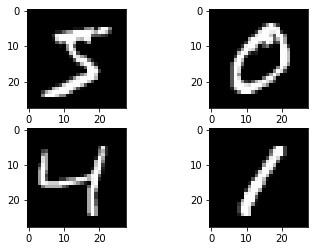

In [14]:
# Display several images
plt.subplot(221)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))
plt.show()

# Train classifier

In [49]:
data = Tensor(x_train, autograd=True)
target = Tensor(y_train, autograd=True)

w = list()
w.append(Tensor(np.random.rand(input_dim, 64), autograd=True))
w.append(Tensor(np.random.rand(64, 10), autograd=True))

lr = 1e-3

for i in range(100):
    # Predict
    pred = data.mm(w[0]).mm(w[1]).softmax()

    # Compare
    loss = ((pred - target) * (pred - target)).sum(0)

    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))

    for w_ in w:
        w_.data -= w_.grad.data * lr
        w_.grad.data *= 0

    print(np.mean(loss.data))

1.7999999999999978
1.4
1.6
1.8
1.7999999999999812
1.7999999999867413
1.8
1.4
1.6
1.8
1.8
1.8
1.8
1.4
1.6
1.8
1.8
1.4
1.8
1.6
1.8
1.8
1.8
1.4
1.8
1.6
1.8
1.8
1.4
1.8
1.8
1.6
1.7999708195102806
1.4
1.8
1.7999999999998473
1.3999999991212886
1.6
1.8
1.4
1.8
1.5916934150478173
1.6
1.7999985158256706
1.4
1.600000000006118
1.5991769042444415
1.5997386642716394
1.7999999999999967
1.4
1.4
1.79999999999959
1.8
1.6
1.61465018379728
1.199999982309274
1.5688856256278043
1.4
1.4
1.4
1.394749002567766
1.199130817769031
1.39999997473632
0.8
0.5916150268343611
0.7973534901306916
0.5999999999999432
0.5999995195253394
1.4
0.7899397088563513
0.7623648364097732
0.5999999999975328
0.9930091716081113
0.9999752111093603
0.9999999999993691
0.5999999984457002
0.7991603443337839
0.8
0.5999999999999064
0.5999999998574951
0.2000011360099816
2.069276441483955e-07
1.3072445385264422e-07
9.073891935010834e-08
6.693804335306375e-08
5.15449378599521e-08
4.098196547350256e-08
3.3402906006374725e-08
2.7771793779534165e-0